# Introduction
This notebook explores the Financial Transactions Dataset to identify fraudulent activities and understand underlying behavioral patterns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
dataframe = pd.read_csv('../../dataset/financial_fraud_detection_dataset.csv')

In [3]:
dataframe.head()

transaction_id                   timestamp sender_account receiver_account  \
0        T100000  2023-08-22T09:22:43.516168      ACC877572        ACC388389   
1        T100001  2023-08-04T01:58:02.606711      ACC895667        ACC944962   
2        T100002  2023-05-12T11:39:33.742963      ACC733052        ACC377370   
3        T100003  2023-10-10T06:04:43.195112      ACC996865        ACC344098   
4        T100004  2023-09-24T08:09:02.700162      ACC584714        ACC497887   

    amount transaction_type merchant_category location device_used  is_fraud  \
0   343.78       withdrawal         utilities    Tokyo      mobile     False   
1   419.65       withdrawal            online  Toronto         atm     False   
2  2773.86          deposit             other   London         pos     False   
3  1666.22          deposit            online   Sydney         pos     False   
4    24.43         transfer         utilities  Toronto      mobile     False   

  fraud_type  time_since_last_transaction  spending_deviation_score  \
0        NaN                          NaN                     -0.21   
1        NaN                          NaN                     -0.14   
2        NaN                          NaN                     -1.78   
3        NaN                          NaN                     -0.60   
4        NaN                          NaN                      0.79   

   velocity_score  geo_anomaly_score payment_channel       ip_address  \
0               3               0.22            card   13.101.214.112   
1               7               0.96             ACH    172.52.47.194   
2              20               0.89            card     185.98.35.23   
3               6               0.37   wire_transfer    107.136.36.87   
4              13               0.27             ACH  108.161.108.255   

  device_hash  
0    D8536477  
1    D2622631  
2    D4823498  
3    D9961380  
4    D7637601

In [4]:
dataframe.dtypes

transaction_id                  object
timestamp                       object
sender_account                  object
receiver_account                object
amount                         float64
transaction_type                object
merchant_category               object
location                        object
device_used                     object
is_fraud                          bool
fraud_type                      object
time_since_last_transaction    float64
spending_deviation_score       float64
velocity_score                   int64
geo_anomaly_score              float64
payment_channel                 object
ip_address                      object
device_hash                     object
dtype: object

In [5]:
categoric_columns = dataframe.select_dtypes(include=['object']).columns.to_list()
for column in categoric_columns:
    uniques = dataframe[column].unique()
    print(f'{column}: {len(uniques)} unique values')

transaction_id: 5000000 unique values
timestamp: 4999998 unique values
sender_account: 896513 unique values
receiver_account: 896639 unique values
transaction_type: 4 unique values
merchant_category: 8 unique values
location: 8 unique values
device_used: 4 unique values
fraud_type: 2 unique values
payment_channel: 4 unique values
ip_address: 4997068 unique values
device_hash: 3835723 unique values


In [6]:
dataframe = dataframe.drop(columns=['transaction_id'])

## Exploratory Data Analysis

## Null Handling

In [7]:
summary_null = pd.DataFrame({
    'Coluna': dataframe.columns,
    'Quantidade': dataframe.isnull().sum(axis=0).values,
    'Porcentagem': (dataframe.isnull().mean() * 100).round(2).values
})
summary_null

Coluna  Quantidade  Porcentagem
0                     timestamp           0         0.00
1                sender_account           0         0.00
2              receiver_account           0         0.00
3                        amount           0         0.00
4              transaction_type           0         0.00
5             merchant_category           0         0.00
6                      location           0         0.00
7                   device_used           0         0.00
8                      is_fraud           0         0.00
9                    fraud_type     4820447        96.41
10  time_since_last_transaction      896513        17.93
11     spending_deviation_score           0         0.00
12               velocity_score           0         0.00
13            geo_anomaly_score           0         0.00
14              payment_channel           0         0.00
15                   ip_address           0         0.00
16                  device_hash           0         0.00

In [8]:
# Alta porcentagem de nulos em fraud_type porque fraudes são a minoria. Fazer um dataframe simples para tornar isso visual.

dataframe[(dataframe['is_fraud'] == False) & (dataframe['fraud_type'].isnull() == False)]

Empty DataFrame
Columns: [timestamp, sender_account, receiver_account, amount, transaction_type, merchant_category, location, device_used, is_fraud, fraud_type, time_since_last_transaction, spending_deviation_score, velocity_score, geo_anomaly_score, payment_channel, ip_address, device_hash]
Index: []

In [9]:
# Verificando se existe uma relação entre time_since_last_transaction e is_fraud
print('Quantidade de fraudes com time_since_last_transaction nulo:', end=' ')
print(dataframe[dataframe['is_fraud'] == True]['time_since_last_transaction'].isnull().sum())

print('Quantidade de fraudes com time_since_last_transaction não nulo:', end=' ')
print(dataframe[dataframe['is_fraud'] == True]['time_since_last_transaction'].notnull().sum())

Quantidade de fraudes com time_since_last_transaction nulo: 0
Quantidade de fraudes com time_since_last_transaction não nulo: 179553


In [10]:
# Logo, so existe um fraud_type para uma is_fraud = True

dataframe['fraud_type'] = dataframe['fraud_type'].fillna('no_fraud')

In [11]:
# Criar nova coluna para manter a informação de uma possível primeira transação
dataframe['is_first_transaction'] = dataframe['time_since_last_transaction'].isnull().astype(int)
dataframe['time_since_last_transaction'] = dataframe['time_since_last_transaction'].fillna(0)

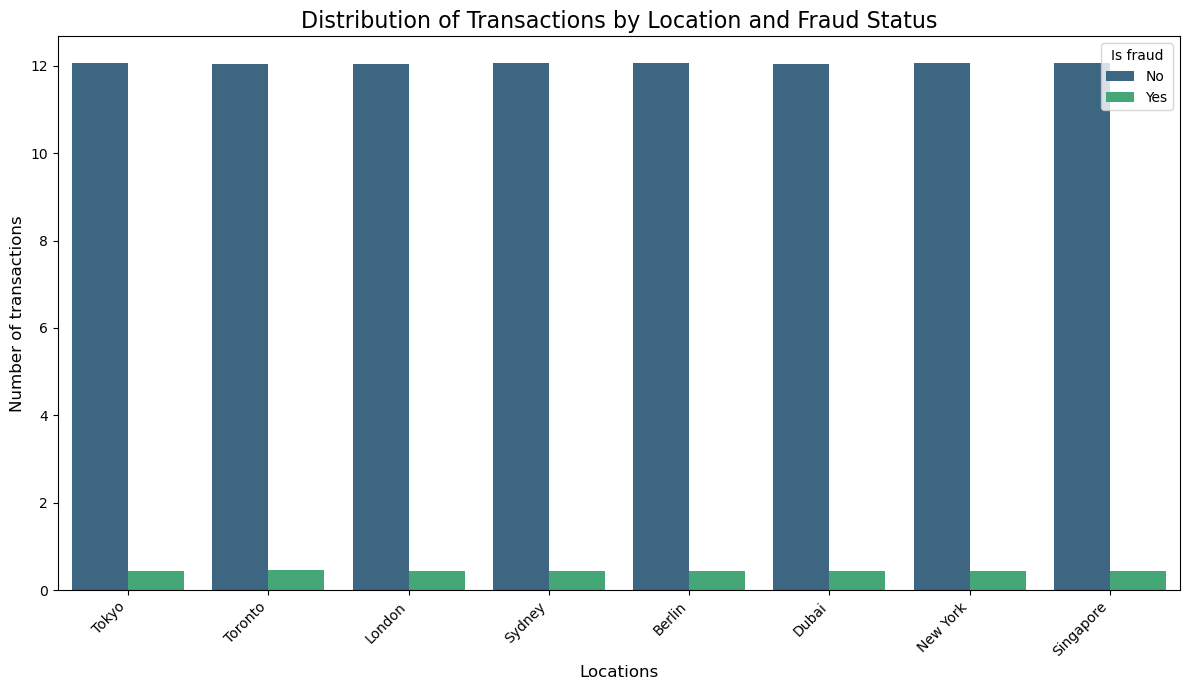

In [12]:
# Plotting the distribution of transactions by location, differentiated by fraud status
plt.figure(figsize=(12, 7))
sns.countplot(data=dataframe, x='location', hue='is_fraud', palette='viridis', stat='percent')
plt.title('Distribution of Transactions by Location and Fraud Status', fontsize=16)
plt.xlabel('Locations', fontsize=12)
plt.ylabel('Number of transactions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is fraud', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

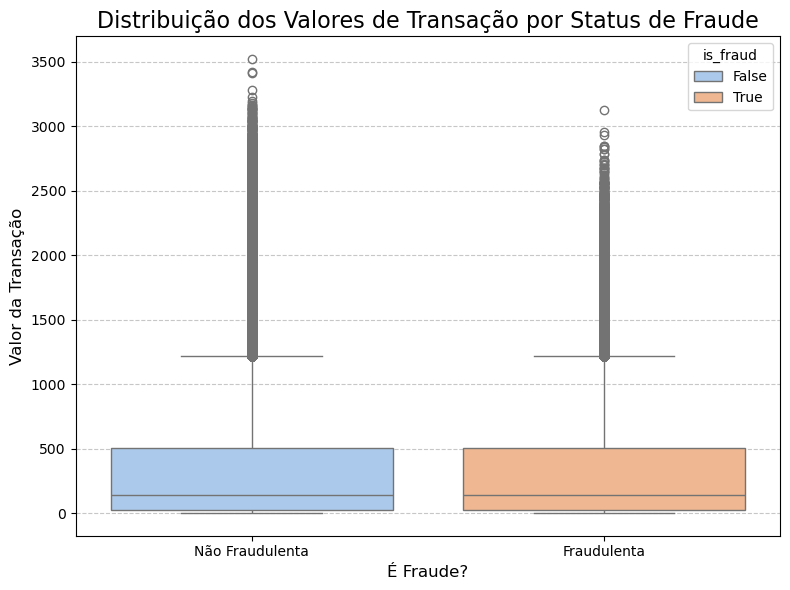

In [13]:
# Criar o box plot para analisar 'amount' em relação a 'is_fraud'
plt.figure(figsize=(8, 6))
sns.boxplot(data=dataframe, x='is_fraud', y='amount', hue='is_fraud', palette='pastel')
plt.title('Distribuição dos Valores de Transação por Status de Fraude', fontsize=16)
plt.xlabel('É Fraude?', fontsize=12)
plt.ylabel('Valor da Transação', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Não Fraudulenta', 'Fraudulenta'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

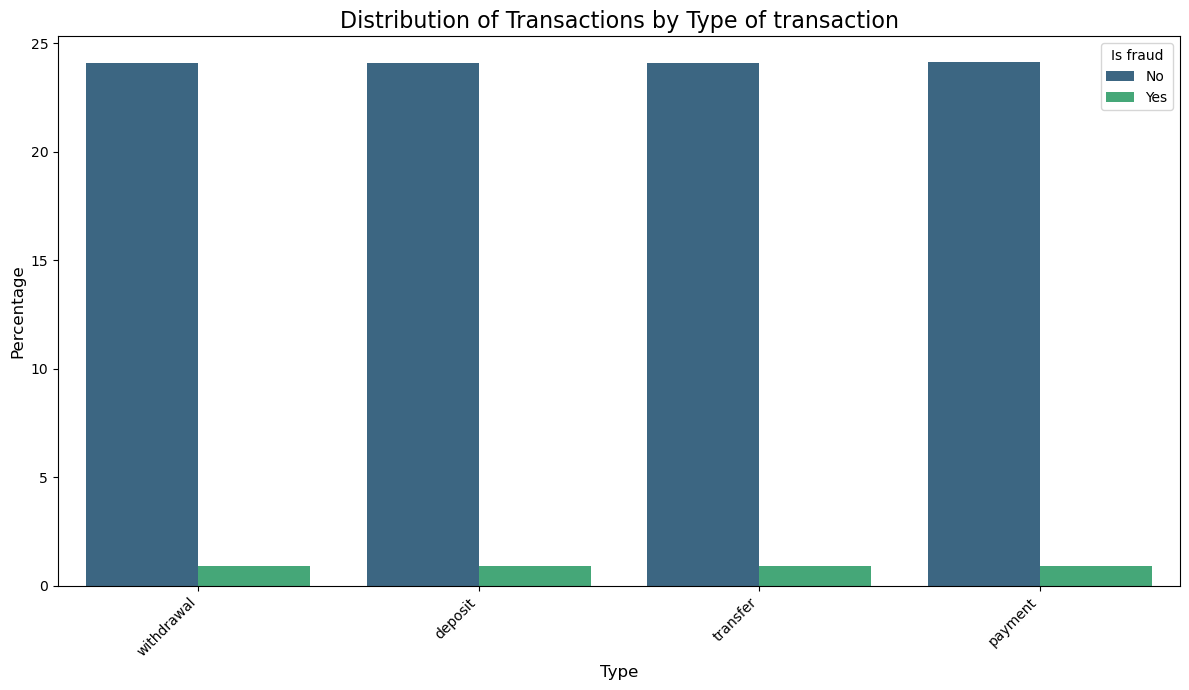

In [14]:
# Plotting the distribution of transactions by transaction type, differentiated by fraud status
plt.figure(figsize=(12, 7))
sns.countplot(data=dataframe, x='transaction_type', hue='is_fraud', palette='viridis', stat='percent')
plt.title('Distribution of Transactions by Type of transaction', fontsize=16)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is fraud', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

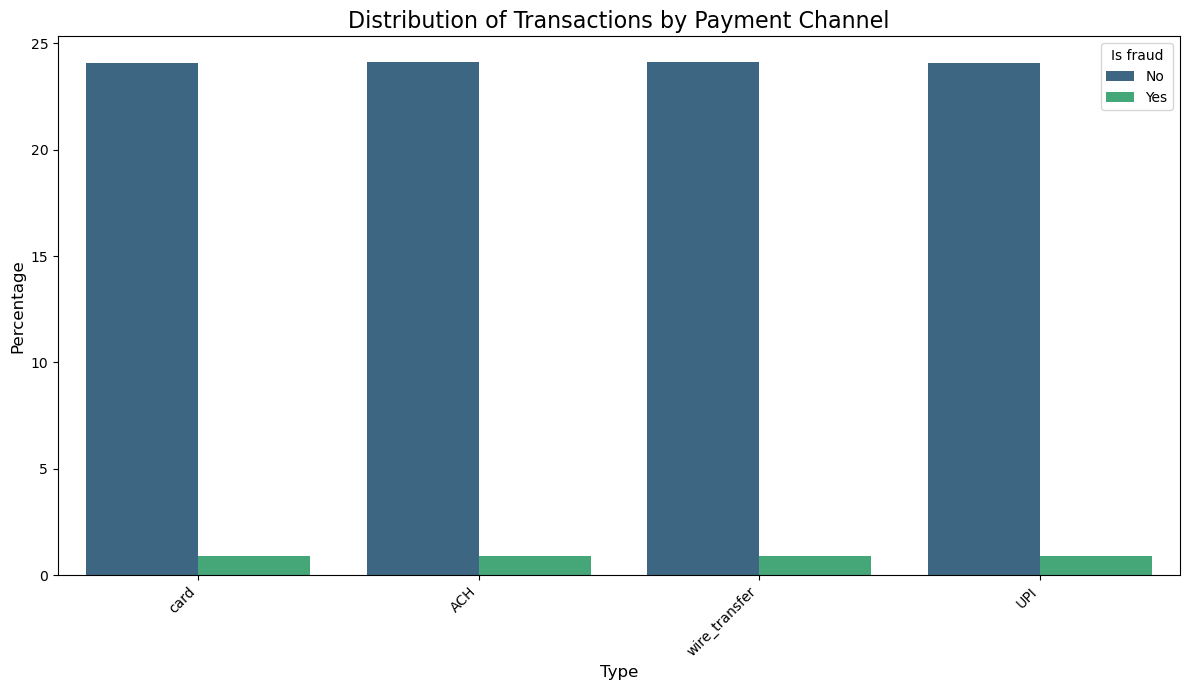

In [15]:
# Plotting the distribution of transactions by payment channel, differentiated by fraud status
plt.figure(figsize=(12, 7))
sns.countplot(data=dataframe, x='payment_channel', hue='is_fraud', palette='viridis', stat='percent')
plt.title('Distribution of Transactions by Payment Channel', fontsize=16)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is fraud', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

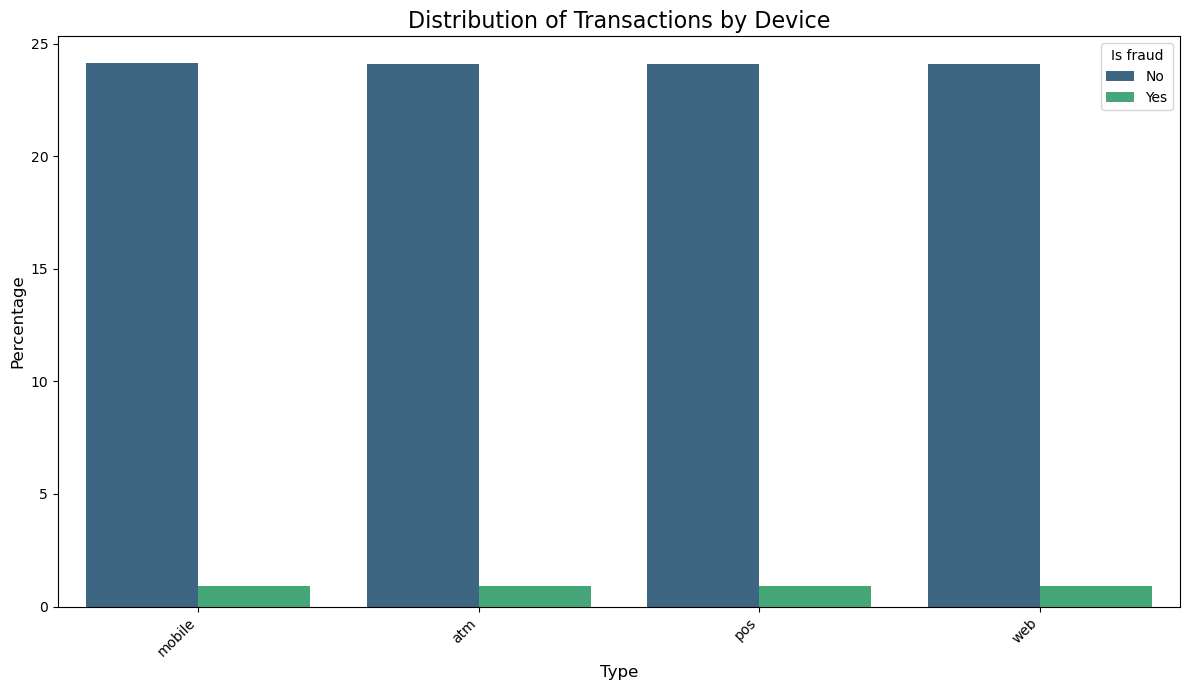

In [16]:
# Plotting the distribution of transactions by payment channel, differentiated by fraud status
plt.figure(figsize=(12, 7))
sns.countplot(data=dataframe, x='device_used', hue='is_fraud', palette='viridis', stat='percent')
plt.title('Distribution of Transactions by Device', fontsize=16)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is fraud', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

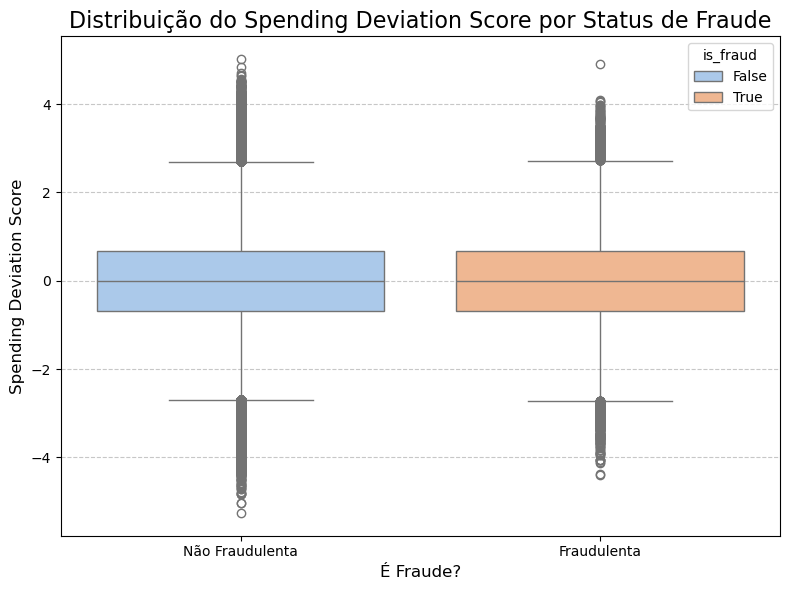

In [17]:
# Criar o box plot para analisar 'spending_deviation_score' em relação a 'is_fraud'
plt.figure(figsize=(8, 6))
sns.boxplot(data=dataframe, x='is_fraud', hue = 'is_fraud', y='spending_deviation_score', palette='pastel')
plt.title('Distribuição do Spending Deviation Score por Status de Fraude', fontsize=16)
plt.xlabel('É Fraude?', fontsize=12)
plt.ylabel('Spending Deviation Score', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Não Fraudulenta', 'Fraudulenta'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

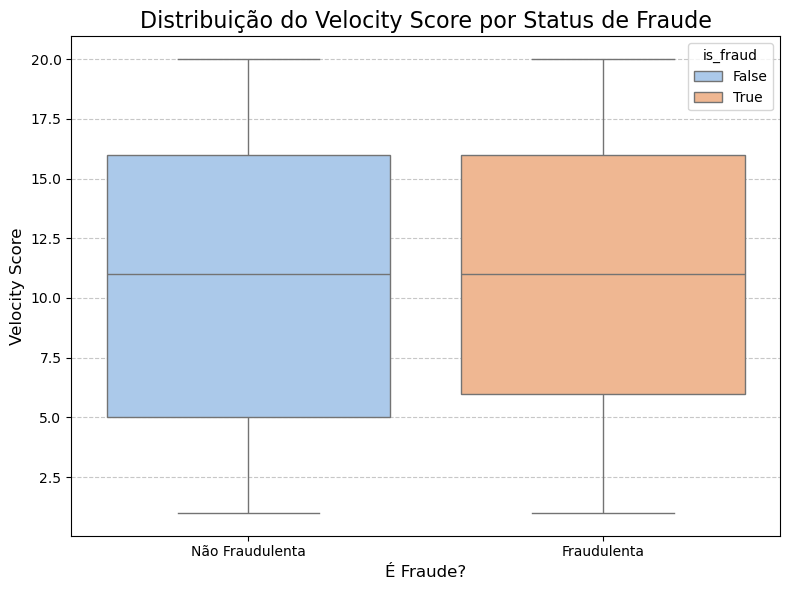

In [18]:
# Criar o box plot para analisar 'velocity_score' em relação a 'is_fraud'
plt.figure(figsize=(8, 6))
sns.boxplot(data=dataframe, x='is_fraud', y='velocity_score',hue='is_fraud', palette='pastel')
plt.title('Distribuição do Velocity Score por Status de Fraude', fontsize=16)
plt.xlabel('É Fraude?', fontsize=12)
plt.ylabel('Velocity Score', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Não Fraudulenta', 'Fraudulenta'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

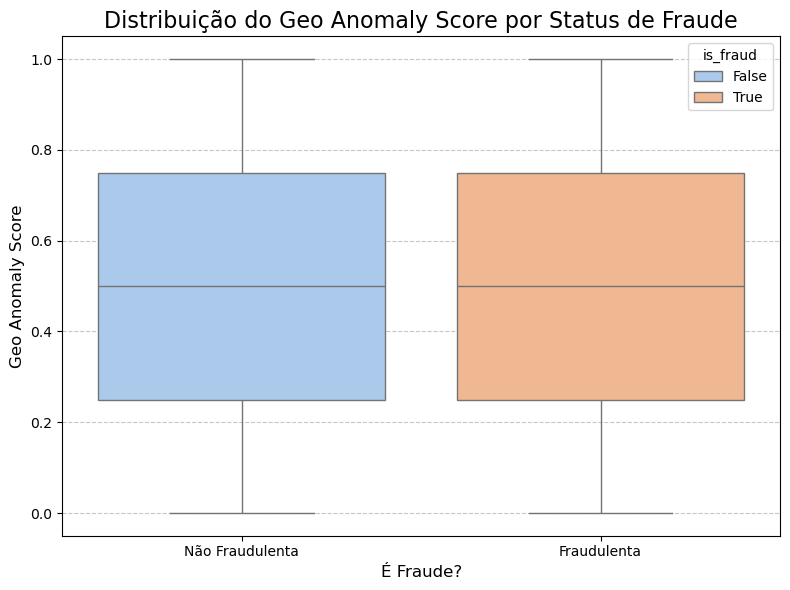

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=dataframe, x='is_fraud', y='geo_anomaly_score',hue='is_fraud', palette='pastel')
plt.title('Distribuição do Geo Anomaly Score por Status de Fraude', fontsize=16)
plt.xlabel('É Fraude?', fontsize=12)
plt.ylabel('Geo Anomaly Score', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Não Fraudulenta', 'Fraudulenta'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], format='ISO8601')

# Extrair o dia da semana
dataframe['day_of_week'] = dataframe['timestamp'].dt.dayofweek

# Extrair a hora
dataframe['hour'] = dataframe['timestamp'].dt.hour

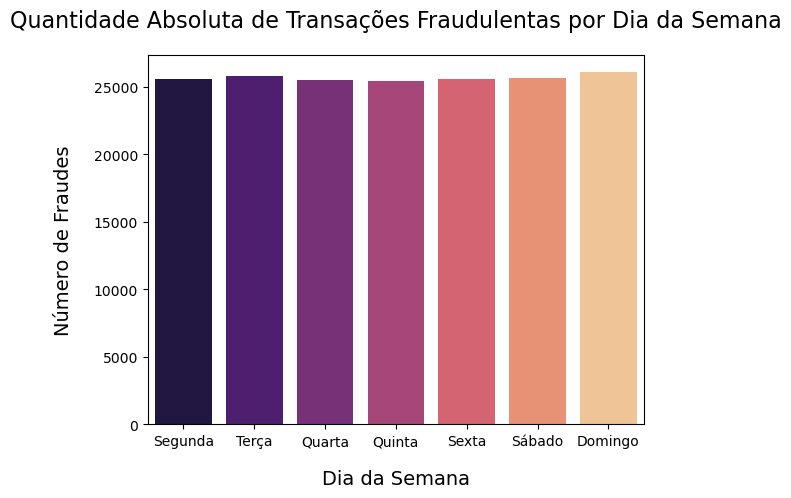

In [21]:



# Mapear os números dos dias da semana para nomes para melhor visualização
day_names = ["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]
dataframe['day_of_week_name'] = dataframe['day_of_week'].map(lambda x: day_names[x])

fraud_counts = dataframe.groupby('day_of_week_name')['is_fraud'].sum()

# Ordenar os resultados pela ordem cronológica dos dias

fraud_counts = fraud_counts.reindex(day_names)

sns.barplot(x=fraud_counts.index, y=fraud_counts.values, hue= fraud_counts.index,palette='magma',legend=False)

# Personalização
plt.title('Quantidade Absoluta de Transações Fraudulentas por Dia da Semana', fontsize=16, pad=20)
plt.xlabel('Dia da Semana', fontsize=14, labelpad=15)
plt.ylabel('Número de Fraudes', fontsize=14, labelpad=15)
plt.show()

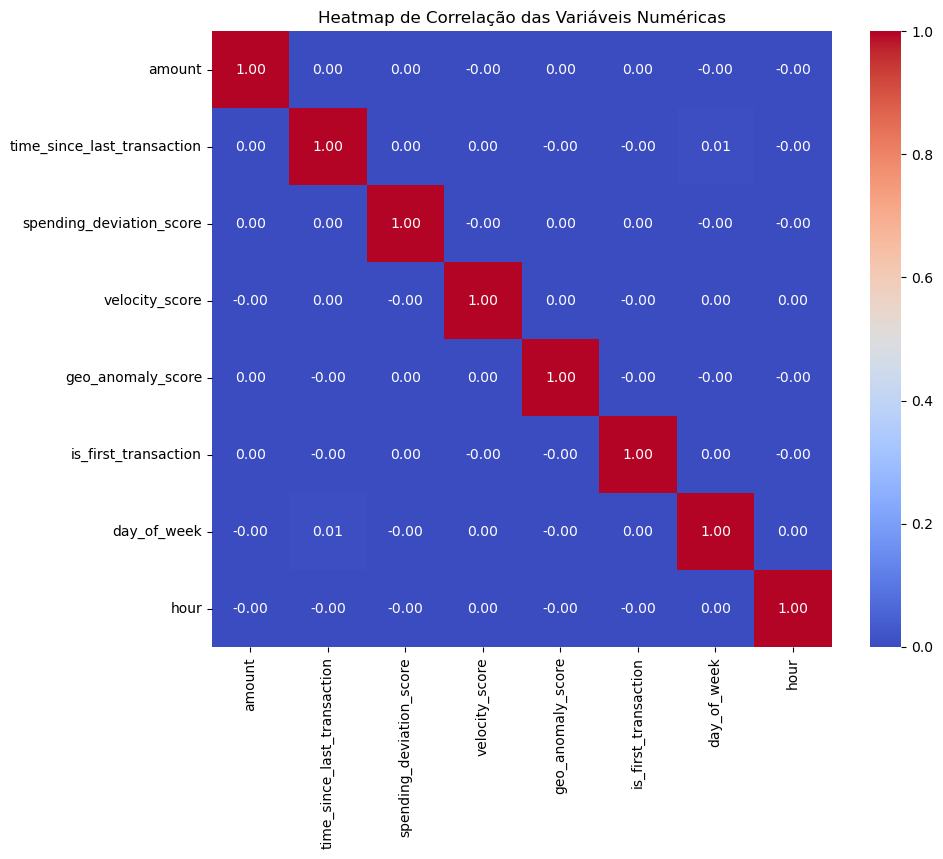

In [22]:
numeric_cols = dataframe.select_dtypes(include=np.number).columns
correlation_matrix = dataframe[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação das Variáveis Numéricas')
plt.show()

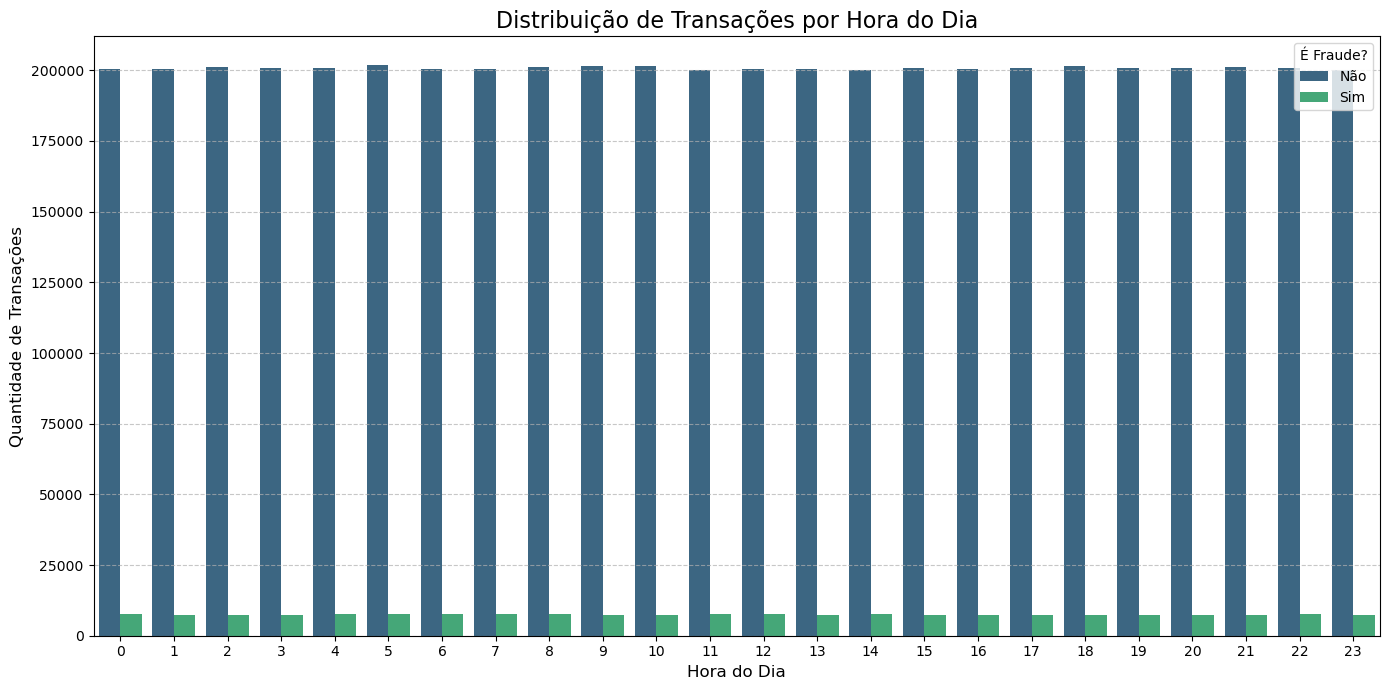

In [23]:

plt.figure(figsize=(14, 7))
sns.countplot(data=dataframe, x='hour', hue='is_fraud', palette='viridis')

plt.title('Distribuição de Transações por Hora do Dia', fontsize=16)
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Quantidade de Transações', fontsize=12)
plt.legend(title='É Fraude?', labels=['Não', 'Sim'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

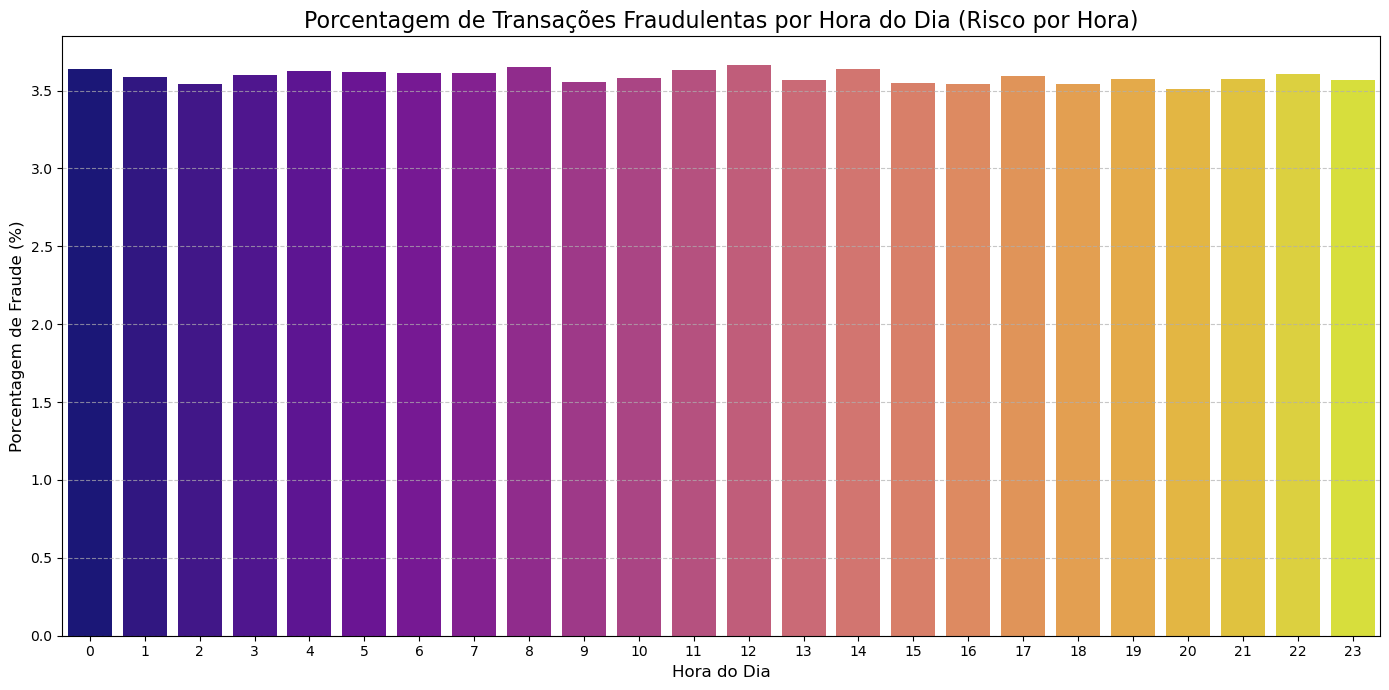

In [24]:
# Agrupar por hora e calcular a porcentagem de fraude
hourly_fraud_percentage = dataframe.groupby('hour')['is_fraud'].mean() * 100
hourly_fraud_percentage = hourly_fraud_percentage.reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=hourly_fraud_percentage, x='hour', y='is_fraud', hue='hour',palette='plasma',legend=False)

plt.title('Porcentagem de Transações Fraudulentas por Hora do Dia (Risco por Hora)', fontsize=16)
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Porcentagem de Fraude (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
df_fraud = dataframe[dataframe['is_fraud'] == True].copy()
df_fraud_sender = df_fraud['sender_account'].value_counts().reset_index()
df_fraud_sender.shape

(161974, 2)

In [26]:
# Fraudulent Account Analysis

df_fraud_sender.columns = ['sender_account', 'fraud_count']
df_fraud_sender.describe()

fraud_count
count  161974.000000
mean        1.108530
std         0.336377
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         7.000000

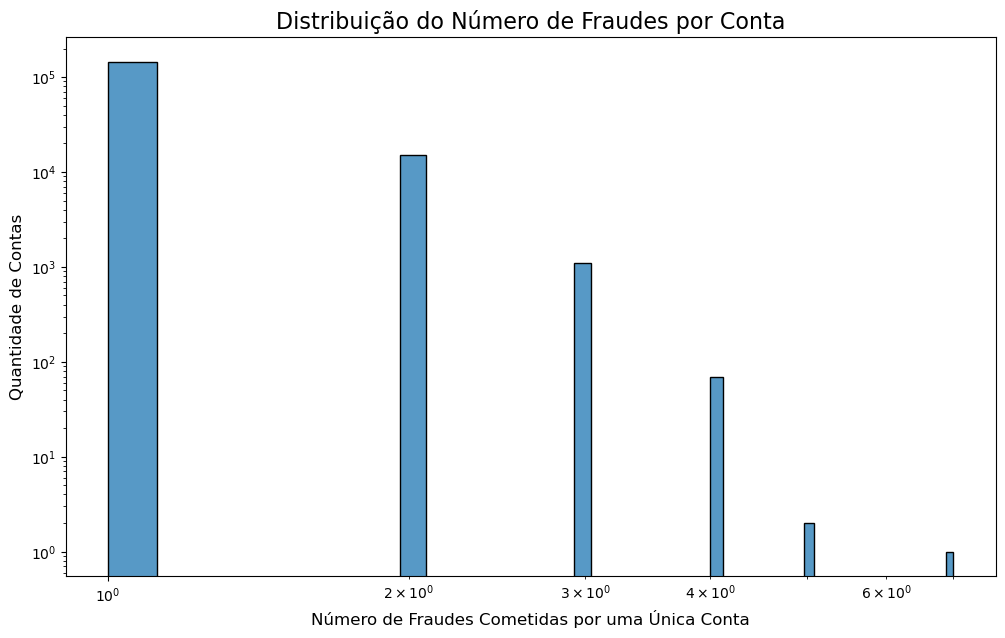

In [27]:
plt.figure(figsize=(12, 7))
sns.histplot(df_fraud_sender['fraud_count'], bins=50, kde=False)
plt.title('Distribuição do Número de Fraudes por Conta', fontsize=16)
plt.xlabel('Número de Fraudes Cometidas por uma Única Conta', fontsize=12)
plt.ylabel('Quantidade de Contas', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [28]:
# Calcular a porcentagem cumulativa de fraudes
total_frauds = df_fraud_sender['fraud_count'].sum()
df_fraud_sorted = df_fraud_sender.sort_values(by='fraud_count', ascending=False)
df_fraud_sorted['cumulative_fraud_percentage'] = (df_fraud_sorted['fraud_count'].cumsum() / total_frauds) * 100

# Descobrir quantas contas são responsáveis por 50% e 80% das fraudes
accounts_for_50_percent = df_fraud_sorted[df_fraud_sorted['cumulative_fraud_percentage'] <= 50].shape[0]
accounts_for_80_percent = df_fraud_sorted[df_fraud_sorted['cumulative_fraud_percentage'] <= 80].shape[0]

total_fraud_accounts = df_fraud_sender.shape[0]

print(f"Total de contas fraudulentas: {total_fraud_accounts}")
print("-" * 50)
print(f"Contas responsáveis por 50% de todas as fraudes: {accounts_for_50_percent} (Apenas {(accounts_for_50_percent/total_fraud_accounts)*100:.2f}%)")
print(f"Contas responsáveis por 80% de todas as fraudes: {accounts_for_80_percent} (Apenas {(accounts_for_80_percent/total_fraud_accounts)*100:.2f}%)")

Total de contas fraudulentas: 161974
--------------------------------------------------
Contas responsáveis por 50% de todas as fraudes: 72197 (Apenas 44.57%)
Contas responsáveis por 80% de todas as fraudes: 126063 (Apenas 77.83%)


In [29]:
# Fraudulent IP Analysis
df_fraud_ip = df_fraud['ip_address'].value_counts().reset_index()
df_fraud_ip.shape

(179547, 2)

In [30]:
df_fraud_ip.columns = ['ip_address', 'fraud_count']
df_fraud_ip.describe()

fraud_count
count  179547.000000
mean        1.000033
std         0.005781
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000

In [31]:
# Analyzing the transaction history of fraudulent accounts

df_fraud_sender_list = df_fraud_sender['sender_account'].tolist()
history_of_fraud_accounts = dataframe[dataframe['sender_account'].isin(df_fraud_sender_list)]

In [32]:
history_of_fraud_accounts.shape

(1078936, 21)

In [33]:
activity_counts_sender = (
    history_of_fraud_accounts
    .groupby(['sender_account', 'is_fraud'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: 'non_fraud_count', True: 'fraud_count'}) 
    .sort_values(by='fraud_count', ascending=False)
)

# --- Exibir os Resultados ---
print(activity_counts_sender.head(20))

is_fraud        non_fraud_count  fraud_count
sender_account                              
ACC367849                     9            7
ACC651812                     7            5
ACC312579                     4            5
ACC181286                     6            4
ACC989828                     4            4
ACC800639                     3            4
ACC450438                     5            4
ACC986969                     6            4
ACC239462                     3            4
ACC464350                     2            4
ACC473532                     8            4
ACC366716                     7            4
ACC546464                     5            4
ACC949246                     8            4
ACC595539                     9            4
ACC493850                     2            4
ACC696111                     8            4
ACC933698                     6            4
ACC983898                     3            4
ACC729947                     4            4


In [34]:
print((activity_counts_sender['non_fraud_count'] > 0).sum())

161974


In [35]:

df_fraud_ip_list = df_fraud_ip['ip_address'].tolist()
history_of_fraud_ip = dataframe[dataframe['ip_address'].isin(df_fraud_ip_list)]

In [36]:
activity_counts_ip = (
    history_of_fraud_ip
    .groupby(['ip_address', 'is_fraud'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: 'non_fraud_count', True: 'fraud_count'}) 
    .sort_values(by='fraud_count', ascending=False)
)
print(activity_counts_ip.head(20))

is_fraud        non_fraud_count  fraud_count
ip_address                                  
184.169.190.94                0            2
164.154.56.189                0            2
208.161.20.182                0            2
57.227.184.128                0            2
103.202.182.14                0            2
25.50.60.119                  0            2
250.80.132.216                0            1
250.81.105.12                 0            1
250.81.219.143                0            1
250.82.215.7                  0            1
250.82.99.191                 0            1
250.84.158.118                0            1
250.84.54.250                 0            1
250.85.185.111                0            1
250.85.254.12                 0            1
250.86.13.192                 0            1
250.86.239.75                 0            1
250.87.198.192                0            1
250.88.75.244                 0            1
250.89.108.181                0            1


In [37]:
print(f"Number of IPs with at least one non-fraudulent transaction: {(activity_counts_ip['non_fraud_count'] > 0).sum()}")

Number of IPs with at least one non-fraudulent transaction: 198


In [38]:
# Calculating the frequency of each IP address in the dataset
ip_counts = dataframe['ip_address'].value_counts()
dataframe['ip_frequency'] = dataframe['ip_address'].map(ip_counts)
dataframe = dataframe.drop(columns=['ip_address'])

In [43]:
# Contar a frequência de cada conta no dataframe inteiro
account_total_counts = dataframe['sender_account'].value_counts()

# Mapear essa contagem de volta para uma nova coluna no dataframe
dataframe['account_total'] = dataframe['sender_account'].map(account_total_counts)

account_fraud = dataframe[dataframe['is_fraud'] == True]['sender_account'].value_counts()
dataframe['account_fraud'] = dataframe['sender_account'].map(account_fraud).fillna(0)

# Calcular a taxa de fraude (evitando divisão por zero)
dataframe['account_fraud_rate'] = (dataframe['account_fraud_tx'] / dataframe['account_total']).fillna(0)

dataframe = dataframe.drop(columns=['sender_account'])